                                             Erwähnung  \
0                            Pfaltzgrafen WolfWilhelms   
1                                                 Duce   
2                     Fürstlichen Pfaltz-Newburgischen   
3                                  Fürstlichen Fräwlin   
4    Durchleuchtiger Hochgeborner Fürst, Euer Fürst...   
..                                                 ...   
348                                        Hugold Beer   
349                                Palatinodi Neoburgo   
350                               princessa di Baviera   
351                               Principe di Neoburgo   
352                                Doctor Haÿlbronners   

                                          Personenname Geburtsjahr Todesjahr  \
0    Wolfgang Wilhelm, Pfalzgraf und Herzog (Pfalz-...        1578      1653   
1    Wolfgang Wilhelm, Pfalzgraf und Herzog (Pfalz-...        1578      1653   
2    Wolfgang Wilhelm, Pfalzgraf und Herzog (Pfalz-...        1

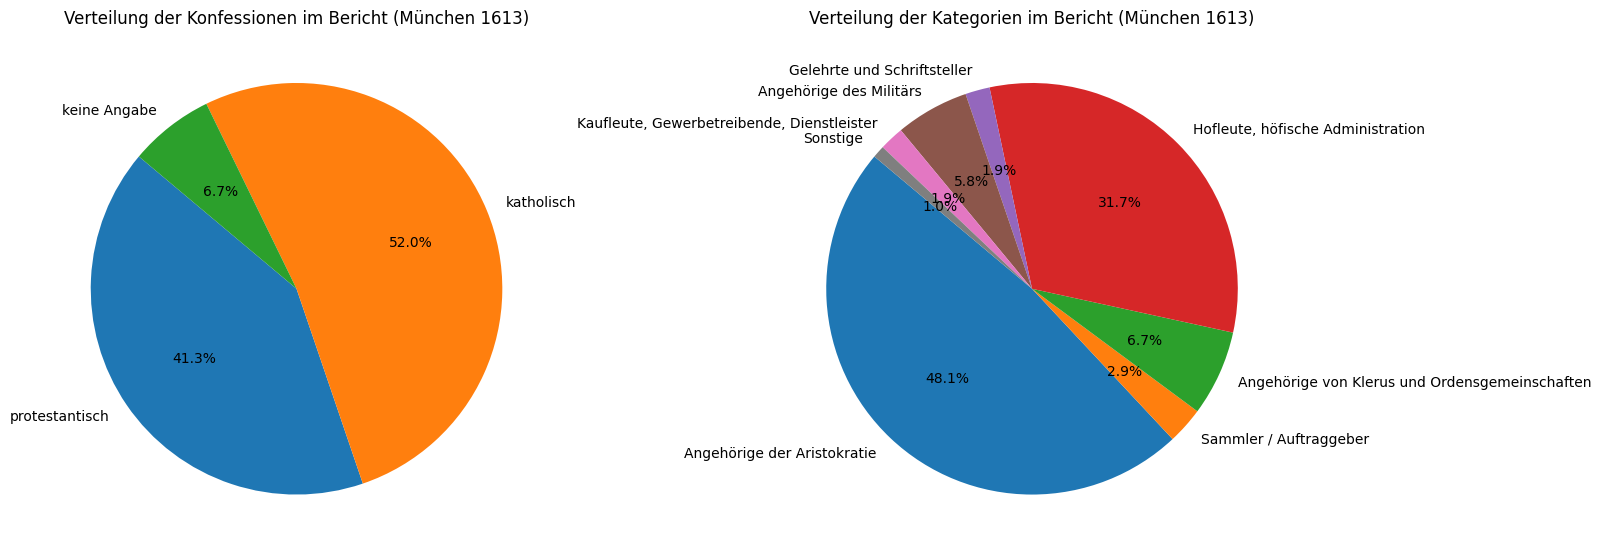

In [4]:
# Personennamen: Normdatenverknüpfung & Metadatenanreicherung

from lxml import etree as ET
import pandas as pd
import re
import os
from collections import Counter
import matplotlib.pyplot as plt

### Schritt 1: Lade die LOD-Mapping-Datei und erstelle das Dictionary psn_to_person

if not os.path.exists('hainhofer-lod.xml'):
    print("Die Datei 'hainhofer-lod.xml' wurde nicht gefunden.")
    exit(1)

lod_file = 'hainhofer-lod.xml'
tree1 = ET.parse(lod_file)
root1 = tree1.getroot()

namespaces = {
    'tei': 'http://www.tei-c.org/ns/1.0',
    'schema': 'http://schema.org/',
    'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#'
}

base_url = 'https://hainhofer.hab.de/register/personen/'

psn_to_person = {}

for person_name in root1.findall('.//rdf:Description', namespaces):
    person = person_name.find('rdfs:label', namespaces)
    psn = person_name.find('schema:mainEntityOfPage', namespaces)

    if person is None or psn is None or not psn.text.startswith(base_url):
        continue

    url = psn.text[len(base_url):].strip()
    person_text = person.text.strip()
    psn_to_person[url] = person_text


### Schritt 2: Lade die XML-Datei und extrahiere persons_list (person_text, psn_name)

user_input = input('Geben Sie das Reiseziel und das Entstehungsjahr Ihres Berichts an (z.B. München 1603):')
input_file = user_input.title() + '.xml'
new_filename = input_file.lower().replace("ä", "ae").replace("ö", "oe").replace("ü", "ue").replace("ü", "ue").replace("ß", "ss").replace(" ", "_")

if not os.path.exists(input_file):
    print('Die gesuchte Datei wurde nicht gefunden.')
    exit(1)

tree2 = ET.parse(input_file)
root2 = tree2.getroot()

namespaces = {'tei': 'http://www.tei-c.org/ns/1.0'}

def extract_text(elem):
    return re.sub(r'\s+', ' ', ''.join(elem.itertext())).strip()

persons = root2.findall('.//tei:rs[@type="person"][@role="present"]', namespaces)

persons_list = []

for elem in persons:
    parent = elem.getparent()
    skip = False
    while parent is not None:
        if parent.tag == 'note' and parent.attrib.get('resp') == '#editor':
            skip = True
            break
        if (parent.tag == 'p' or parent.tag == 'div') and parent.attrib.get('hand') == '#fremde_hand':
            skip = True
            break
        parent = parent.getparent()

    if skip:
        continue

    ref = elem.get('ref', None)
    if not ref or not ref.startswith('psn:'):
        continue

    psn_name = ref[4:]
    person_text = extract_text(elem)
    persons_list.append((person_text, psn_name))


### Schritt 3: Erstelle ein Dictionary: Zuordnung person_text → LOD-Personenname mittels psn_to_person

normalization = {}

for person_text, psn_name in persons_list:
    person_name = psn_to_person.get(psn_name)
    if person_name:
        normalization[person_text] = person_name

df_normalized = pd.DataFrame(normalization.items(), columns=['Erwähnung', 'Personenname'])


### Schritt 4: Parsen des XHTML-Registers zur Erfassung von Personenmetadaten

def extract_text(entry, xpath_expr):
    result = entry.xpath(xpath_expr)
    return result[0].strip() if result else ''

def extract_list_text(entry, xpath_expr):
    items = entry.xpath(xpath_expr)
    texts = []
    for item in items:
        if isinstance(item, str):
            text = item.strip()
        else:
            text = ''.join(item.itertext()).strip()
        text = re.sub(r'\s+', ' ', text)
        if text:
            texts.append(text)
    return '; '.join(texts)

if not os.path.exists('register.xhtml'):
    print("Die Datei 'register.xhtml' wurde nicht gefunden.")
    exit(1)

with open('register.xhtml', 'rb') as f:
    tree = ET.parse(f, ET.HTMLParser())

entries = tree.xpath('//div[@id="psn"]/div[contains(@class, "entry")]')

birth_year_text = "Angaben zum Geburtsjahr"
death_year_text = "Angaben zum Todesjahr"

def extract_years(text):
    if not text:
        return (None, None)

    text = re.sub(r'\bca\.?\s*', '', text, flags=re.IGNORECASE)

    # Muster 1: zwischen X v. Chr. und Y n. Chr.
    match = re.search(r'zwischen\s+(\d+)\s+v\.?\s*Chr\.?\s+und\s+(\d+)', text, re.IGNORECASE)
    if match:
        year1 = -int(match.group(1))
        year2 = int(match.group(2))
        return min(year1, year2), max(year1, year2)

    # Muster 2: zwischen X und Y (beide v. Chr.)
    match = re.findall(r'(\d+)\s+v\.?\s*Chr\.?', text, re.IGNORECASE)
    if len(match) > 1:
        years = sorted([-int(y) for y in match])
        return years[0], years[-1]

    # Muster 3: zwischen X und Y (beide n. Chr.)
    match = re.search(r'zwischen\s+(\d+)\s+und\s+(\d+)', text, re.IGNORECASE)
    if match:
        years = sorted([int(match.group(1)), int(match.group(2))])
        return years[0], years[1]

    # Muster 4: genaue Jahreszahl (v. Chr.)
    match = re.search(r'(\d+)\s+v\.?\s*Chr\.?', text, re.IGNORECASE)
    if match:
        year = -int(match.group(1))
        return year, year

    # Muster 5: genaue Jahreszahl (n. Chr.)
    match = re.findall(r'(\d{3,4})', text)
    if match:
        years = sorted([int(y) for y in match])
        return years[0], years[-1]

    return (None, None)

persons = []

for entry in entries:
    name = extract_text(entry, './/h1[@class="prefname"]/text()')

    lifetime = extract_list_text(entry, './/div[@class="birthdeath"]/p/text()')

    birth_span = extract_years(lifetime)
    death_span = extract_years(lifetime[lifetime.find("✝"):]) if "✝" in lifetime else (None, None)

    birth_year = birth_span[0]  # das frühere Jahr für Geburt
    death_year = death_span[1]  # das spätere Jahr für Tod

    if birth_year is not None and birth_year < 1500:
        continue
    if death_year is not None and death_year < 1600:
        continue

    category = extract_list_text(entry, './/div[@class="categorycontainer"]//li')
    excluded = ['Biblische Personen, Heilige', 'Mythologische Personen', 'Personifikationen']
    if any(cat in category for cat in excluded):
        continue

    faith = extract_list_text(entry, './/div[@class="faithcontainer"]//li/text()')

    persons.append({
        'Personenname': name,
        'Geburtsjahr': str(birth_year) if birth_year is not None else '',
        'Todesjahr': str(death_year) if death_year is not None else '',
        'Kategorie': category,
        'Konfession': faith
    })

df_register = pd.DataFrame(persons)

def clean_cell(value):
    if isinstance(value, list):
        return '; '.join([v.strip() if isinstance(v, str) else str(v) for v in value])
    elif isinstance(value, str):
        return value.strip()
    else:
        return '' if pd.isna(value) else str(value).strip()

for col in df_register.columns:
    df_register[col] = df_register[col].apply(clean_cell)


### Schritt 5: Zusammenführen der normalisierten Erwähnungen mit den Metadaten aus dem Register

df_normalized['Personenname'] = df_normalized['Personenname'].str.strip()
df_register['Personenname'] = df_register['Personenname'].str.strip()

merged_df = pd.merge(df_normalized, df_register, on='Personenname', how='left').fillna('').astype(str)

print(merged_df)


### Schritt 6: Speichern des zusammengeführten DataFrames

output_xlsx = new_filename.replace('.xml', '_personen_mit_metadaten.xlsx')
output_csv = new_filename.replace('.xml', '_personen_mit_metadaten.csv')

merged_df.to_excel(output_xlsx, index=False)
merged_df.to_csv(output_csv, sep=';', index=False, encoding='utf-8-sig')


### Schritt 7: Visualisierung der Verteilung der Konfessionen und Kategorien im Bericht

# Erstellt einen DataFrame mit eindeutigen Personen, um jede Person nur einmal zu zählen.
unique_persons_df = merged_df.drop_duplicates(subset=['Personenname']).copy()

# Flache Liste aller Konfessionen und Kategorien aus dem DataFrame der eindeutigen Personen
all_konfessionen = [item.strip() for sublist in unique_persons_df['Konfession'].str.split(';') for item in sublist if item.strip()]
all_kategorien = [item.strip() for sublist in unique_persons_df['Kategorie'].str.split(';') for item in sublist if item.strip()]

# Häufigkeit jeder Konfession und Kategorie zählen.
konf_counts = Counter(all_konfessionen)
kat_counts = Counter(all_kategorien)

# Diagramme mit Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Kuchendiagramm für Konfessionen
# Wir prüfen, ob Daten vorhanden sind, um Fehler zu vermeiden.
if konf_counts:
    ax1.pie(konf_counts.values(), labels=konf_counts.keys(), autopct='%1.1f%%', startangle=140)
    ax1.set_title(f'Verteilung der Konfessionen im Bericht ({user_input})')
else:
    ax1.set_title('Keine Konfessionsdaten vorhanden')
    ax1.axis('off')

# Kuchendiagramm für Kategorien
# Prüfen, ob Kategorien vorhanden sind, um Fehler zu vermeiden
if kat_counts:
    ax2.pie(kat_counts.values(), labels=kat_counts.keys(), autopct='%1.1f%%', startangle=140)
    ax2.set_title(f'Verteilung der Kategorien im Bericht ({user_input})')
else:
    ax2.set_title('Keine Kategoriendaten vorhanden')
    ax2.axis('off')

# Optimale Layout-Anpassung und Anzeigen der Diagramme
plt.tight_layout()
plt.show()

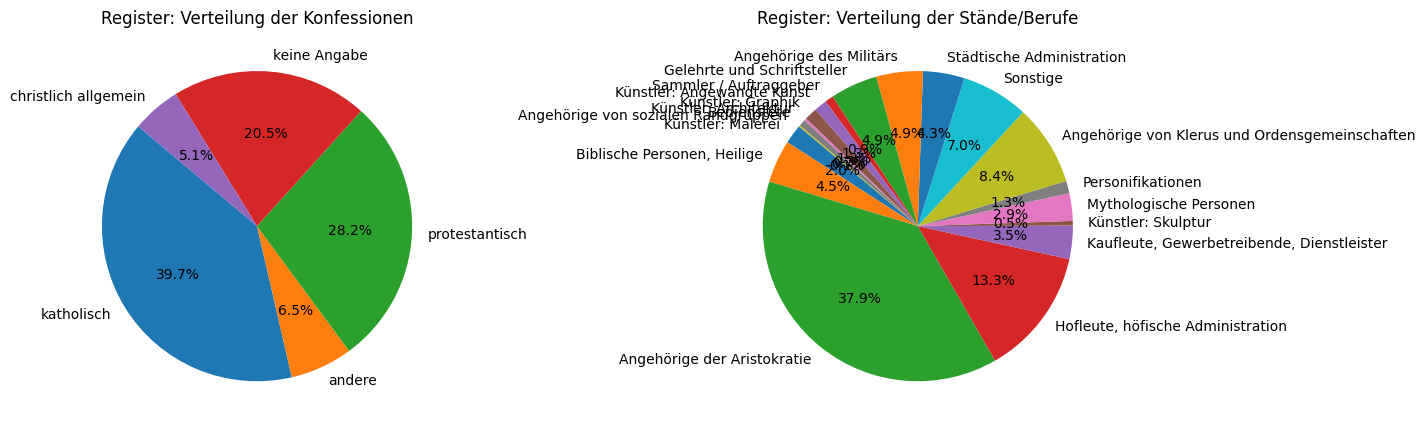

In [2]:
# --- Visualisierung der Konfessionen und Kategorien im Personenregister ---

from lxml import etree
from collections import Counter
import matplotlib.pyplot as plt
import os

# 1. Überprüfen, ob die XHTML-Datei existiert
file_path = "register.xhtml"
if not os.path.exists(file_path):
    print(f"Fehler: Die Datei '{file_path}' wurde nicht gefunden.")
    # Exit the script gracefully if the file is not there
    exit(1)

# 2. XHTML-Datei öffnen und parsen
try:
    with open(file_path, "rb") as f:
        tree = etree.parse(f, etree.HTMLParser())
except Exception as e:
    print(f"Fehler beim Parsen der Datei '{file_path}': {e}")
    exit(1)

entries = tree.xpath('//div[@id="psn"]/div[contains(@class, "entry")]')

# Listen für Konfessionen und Kategorien
konfessionen = []
kategorien = []

for entry in entries:
    # Konfessionen und Kategorien extrahieren
    konf_items = entry.xpath('.//div[@class="faithcontainer"]//li/text()')
    for item in konf_items:
        konfessionen.append(item.strip())
        
    kat_items = entry.xpath('.//div[@class="categorycontainer"]//li//text()')
    for item in kat_items:
        kategorien.append(item.strip())

# Häufigkeiten zählen
konf_counts = Counter(konfessionen)
kat_counts = Counter(kategorien)

# 3. Figure und Subplots für die Diagramme erstellen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Kuchendiagramm für Konfessionen
ax1.pie(konf_counts.values(), labels=konf_counts.keys(), autopct='%1.1f%%', startangle=140)
ax1.set_title('Register: Verteilung der Konfessionen')

# Kuchendiagramm für Kategorien
ax2.pie(kat_counts.values(), labels=kat_counts.keys(), autopct='%1.1f%%', startangle=140)
ax2.set_title('Register: Verteilung der Stände/Berufe')

# 4. Diagramme anzeigen
plt.tight_layout()
plt.show()